# Options sur devises

In [51]:
# Some useful imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## Simulation de trajectoires sous la probabilité risque neutre

In [52]:
def simulate(S0, sigma, r0, r1, N, T):
    S = np.zeros(N)
    dt = T/N
    S[0] = S0
    for i in range(1, N):
        Z = np.random.normal(0, 1)
        S[i] = S[i-1] + S[i-1] * (sigma * np.sqrt(dt) * Z + (r0-r1) * dt)
    return S

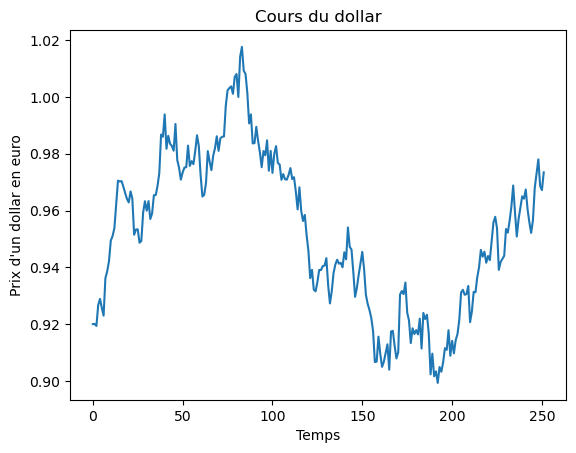

In [60]:
# Paramètres
S0 = 0.92
sigma = 0.1
r0 = 0.1
r1 = 0.07
N = 252
T = 1
K = 0.89

# Simulation
S = simulate(S0, sigma, r0, r1, N, T)

# Affichage
plt.plot(S)
plt.title("Cours du dollar")
plt.xlabel("Temps")
plt.ylabel("Prix d'un dollar en euro")
plt.savefig("cours-dollar.png")
plt.show()

## Prix et Delta

In [36]:
def F(t, x, K, sigma, r0, r1, T):
    d1 = (np.log(x/K)+(r0-r1+(sigma**2/2)*(T-t)))/(sigma*np.sqrt(T-t))
    d2 = d1 - sigma*np.sqrt(T-t)
    return x*np.exp(-r1*(T-t))*norm.cdf(d1) - K*np.exp(-r0*(T-t))*norm.cdf(d2)

def delta(t, x, K, sigma, r0, r1, T):
    d = np.log(x * np.exp(-r1*(T-t)) / (K * np.exp(-r0*(T-t)))) / (sigma*np.sqrt(T-t))
    d += sigma*np.sqrt(T-t)/2
    return np.exp(-r1*(T-t)) * norm.cdf(d)

def hedging(S, N, T, K, sigma, r0, r1):
    H0 = np.zeros(N)
    H = np.zeros(N)
    for i in range(N):
        t = i*T/N
        H[i] = delta(t, S[i], K, sigma, r0, r1, T)
        H0[i] = F(t, S[i], K, sigma, r0, r1, T) - H[i]*S[i]
    return H0, H

def value(H0, H, S):
    return H0 + H * S

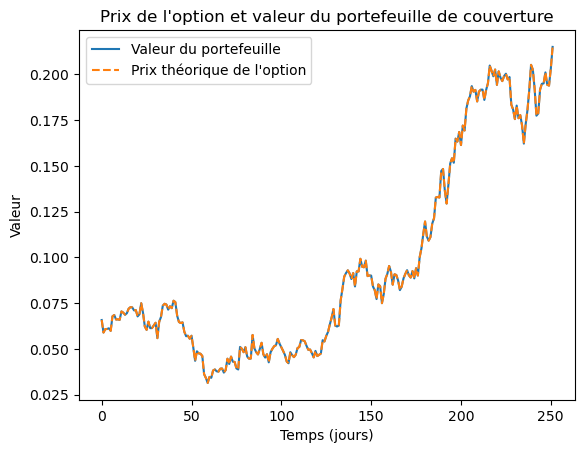

In [37]:
H0, H = hedging(S, N, T, K, sigma, r0, r1)
portfolio_value = value(H0, H, S)

# Valeur réelle de l’option à chaque date
F_real = np.array([F(i*T/N, S[i], K, sigma, r0, r1, T) for i in range(N)])

# Affichage
plt.plot(portfolio_value, label="Valeur du portefeuille")
plt.plot(F_real, linestyle='--', label="Prix théorique de l'option")
plt.title("Prix de l'option et valeur du portefeuille de couverture")
plt.xlabel("Temps (jours)")
plt.ylabel("Valeur")
plt.legend()
plt.show()

## Exercice de couverture

In [91]:
def monte_carlo(S0, sigma, mu, N, T, K, n=10000):
    values = []
    eps = 0.001
    for _ in range(n):
        S = simulate(S0, sigma, mu, 0, N, T)[-1]
        H = delta(T-eps, S, K, sigma, mu, 0, T)
        H0 = F(T-eps, S, K, sigma, mu, 0, T) - H*S
        V = H0 + H*S
        payoff = max(S-K, 0)
        values.append((V-payoff)**2)
    return np.mean(values)

In [120]:
# Exemple d'appel
S0 = 1.08
sigma = 0.2
mu = 1.05
T = 1
N = 50
K = 1.04
n = 10000

erreur_moyenne = monte_carlo(S0, sigma, mu, N, T, K, n)
print("Erreur quadratique moyenne :", erreur_moyenne)

Erreur quadratique moyenne : 1.1912126793585413e-06


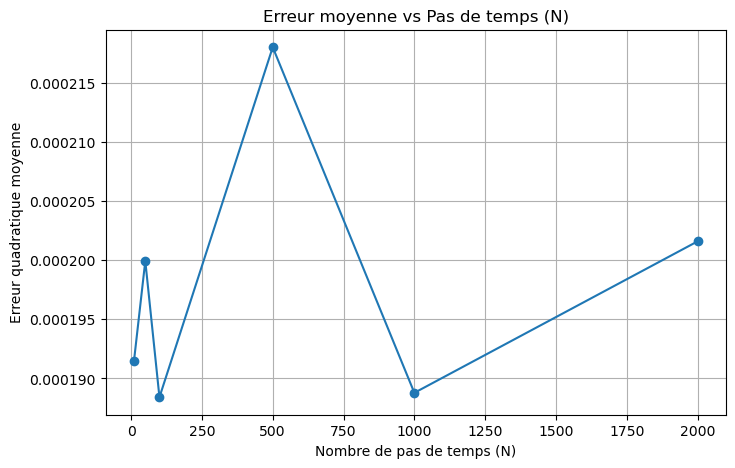

In [93]:
# Variation de l'erreur selon le pas de temps N
N_values = [10, 50, 100, 500, 1000, 2000]
errors = [monte_carlo(S0, sigma, mu, N, T, K, n) for N in N_values]

# Tracé
plt.figure(figsize=(8, 5))
plt.plot(N_values, errors, marker='o')
plt.xlabel("Nombre de pas de temps (N)")
plt.ylabel("Erreur quadratique moyenne")
plt.title("Erreur moyenne vs Pas de temps (N)")
plt.grid(True)
plt.show()

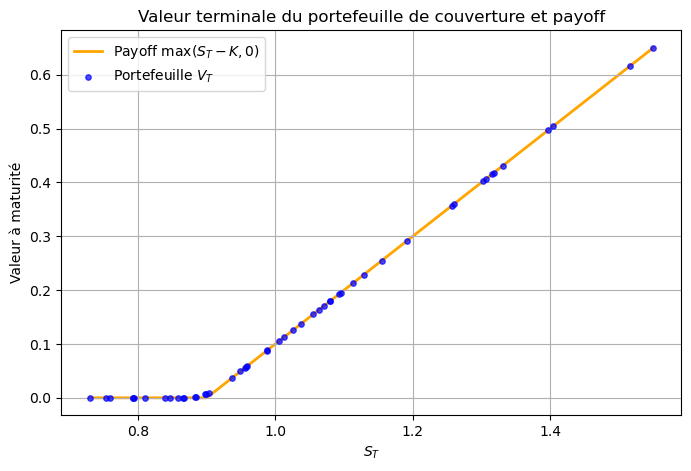

In [131]:
# Générer les points (ST, VT) et (ST, payoff)
def simulate_ST_VT(S0, sigma, mu, N, T, K, n):
    ST_list = []
    VT_list = []
    payoff_list = []
    eps = 0.01
    for _ in range(n):
        S = simulate(S0, sigma, mu, 0, N, T)[-1]
        H = delta(T - eps, S, K, sigma, 0, 0, T)
        H0 = F(T - eps, S, K, sigma, 0, 0, T) - H * S
        VT = H0 + H * S
        payoff = max(S - K, 0)
        ST_list.append(S)
        VT_list.append(VT)
        payoff_list.append(payoff)
    return ST_list, VT_list, payoff_list

# Paramètres
S0 = 1
sigma = 0.2
mu = 0.08
T = 1
K = 0.9
N = 10
n = 50

# Simulation
ST, VT, payoff = simulate_ST_VT(S0, sigma, mu, N, T, K, n)

# Payoff théorique
x = np.linspace(min(ST), max(ST), 500)
payoff_curve = np.maximum(x - K, 0)

# Tracé
plt.figure(figsize=(8, 5))
plt.plot(x, payoff_curve, label="Payoff $\\max(S_T - K, 0)$", color='orange', linewidth=2, zorder=1)
plt.scatter(ST, VT, alpha=0.7, label="Portefeuille $V_T$", s=15, c='blue', zorder=2)
plt.xlabel("$S_T$")
plt.ylabel("Valeur à maturité")
plt.title("Valeur terminale du portefeuille de couverture et payoff")
plt.legend()
plt.grid(True)
plt.show()